# Task 2 - Multi Layer Perceptron Classification

In [1]:
import os
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer as LB
from sklearn.preprocessing import MultiLabelBinarizer as MLB
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, hamming_loss

## Task 2.1 - Model Building from Scratch

## Task 2.1.1 - MLP class with customizable learning rate, activation function, optimiser, number of hidden layers and neurons

In [2]:
wine_df = pd.read_csv("./Data/WineQT.csv")
wine_df = wine_df.drop(columns=["Id"])
wine_df_values = wine_df.to_numpy()
display(wine_df)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6


In [3]:
np.random.seed(0)

wine_df_X, wine_df_Y = wine_df_values[:, :-1], wine_df_values[:, -1]

wine_train_X, wine_val_test_X, wine_train_Y, wine_val_test_Y = train_test_split(wine_df_X, wine_df_Y, random_state=0)
wine_val_X,   wine_test_X,     wine_val_Y,   wine_test_Y     = train_test_split(wine_val_test_X, wine_val_test_Y, train_size=0.6, random_state=0)

In [4]:
# Replacing missing values with mean of the respective columns/features
wine_train_X = SimpleImputer().fit_transform(wine_train_X)
wine_val_X   = SimpleImputer().fit_transform(wine_val_X)
wine_test_X  = SimpleImputer().fit_transform(wine_test_X)

# Dataset normalization
wine_train_X = normalize(wine_train_X)
wine_val_X   = normalize(wine_val_X)
wine_test_X  = normalize(wine_test_X)

# Dataset standardization
wine_train_X = StandardScaler().fit_transform(wine_train_X)
wine_val_X   = StandardScaler().fit_transform(wine_val_X)
wine_test_X  = StandardScaler().fit_transform(wine_test_X)

In [5]:
class MLP():
    def __init__(self, lr=0.001, epochs=1000, activation='sigmoid', optimiser='SGD', num_batches=10, num_layers=2, num_neurons=np.array([15, 12]), multiLabel=False, label_threshold=0.2, progress=True):
        self.lr              = lr
        self.epochs          = epochs
        self.activation      = activation
        self.optimiser       = optimiser
        self.num_batches     = num_batches
        self.num_layers      = num_layers
        self.num_neurons     = num_neurons
        self.weights         = []
        self.biases          = []
        self.inner_outputs   = []
        self.one_hot_encoder = None
        self.multiLabel      = multiLabel
        self.label_threshold = label_threshold
        self.progress        = progress

    def __fit_one_hot(self, y):
        self.one_hot_encoder = LB()
        return self.one_hot_encoder.fit_transform(y)
    
    def __fit_multi_label_one_hot(self, y):
        self.one_hot_encoder = MLB()
        return self.one_hot_encoder.fit_transform(y)
    
    def __get_one_hot(self, y):
        return self.one_hot_encoder.transform(y)

    def __init_weights_biases(self, num_features, num_classes, rand=True):
        if rand is True:
            self.weights.append(np.random.randn(num_features, self.num_neurons[0]))
            self.biases.append( np.random.randn(1, self.num_neurons[0]))

            for i in range(self.num_layers - 1):
                self.weights.append(np.random.randn(self.num_neurons[i], self.num_neurons[i + 1]))
                self.biases.append( np.random.randn(1, self.num_neurons[i + 1]))

            self.weights.append(np.random.randn(self.num_neurons[-1], num_classes))
            self.biases.append( np.random.randn(1, num_classes))            

        else:
            self.weights.append(np.zeros((num_features, self.num_neurons[0])))
            self.biases.append( np.zeros((1, self.num_neurons[0])))

            for i in range(self.num_layers - 1):
                self.weights.append(np.zeros((self.num_neurons[i], self.num_neurons[i + 1])))
                self.biases.append( np.zeros((1, self.num_neurons[i + 1])))

            self.weights.append(np.zeros((self.num_neurons[-1], num_classes)))
            self.biases.append( np.zeros((1, num_classes)))

    def __init_inner_outputs(self, num_samples, num_classes):
        for i in range(self.num_layers):
            self.inner_outputs.append(np.zeros((num_samples, self.num_neurons[i])))
        self.inner_outputs.append(np.zeros((num_samples, num_classes)))

    # Activation functions
    def __sigmoid(self, X):
        X_trunc = X - np.max(X, axis=1)[:, None]
        return np.exp(X_trunc) / np.sum(np.exp(X_trunc), axis=1)[:, None]
    
    def __tanh(self, X):
        return np.tanh(X)
    
    def __relu(self, X):
        return (np.maximum(0, X) % 1e9) + 1e-8

    def __activation(self, X, activation_type=None):
        activation_type = activation_type or self.activation

        if activation_type == 'sigmoid':
            return self.__sigmoid(X)
        elif activation_type == 'tanh':
            return self.__tanh(X)
        elif activation_type == 'relu':
            return self.__relu(X)
    
    # Derivatives of activation functions to be used in backpropagation
    def __sigmoid_derivative(self, X):
        return X * (1 - X)
    
    def __tanh_derivative(self, X):
        return 1 - np.square(X)
    
    def __relu_derivative(self, X):
        return np.where(X > 0, 1, 0)

    def __activation_derivative(self, X, activation_type=None):
        activation_type = activation_type or self.activation
        
        if activation_type == 'sigmoid':
            return self.__sigmoid_derivative(X)
        elif activation_type == 'tanh':
            return self.__tanh_derivative(X)
        elif activation_type == 'relu':
            return self.__relu_derivative(X)
        
    def __softmax(self, X):
        X_trunc = X - np.max(X, axis=1)[:, None]
        return np.exp(X_trunc) / np.sum(np.exp(X_trunc), axis=1)[:, None]

    def __forward_prop(self, X):
        self.inner_outputs[0] = self.__activation(X @ self.weights[0] + self.biases[0])

        for i in range(1, self.num_layers + 1):
            activation_type = 'relu' if i == self.num_layers else self.activation
            self.inner_outputs[i] = self.__activation(self.inner_outputs[i - 1] @ self.weights[i] + self.biases[i], activation_type=activation_type)

        self.inner_outputs[-1] = self.__softmax(self.inner_outputs[-1])

    def __SGD(self, X, y_one_hot):
        for j in range(X.shape[0]):
            for i in range(self.num_layers, -1, -1):
                activation_type = 'relu' if i == self.num_layers else self.activation

                if i == self.num_layers:
                    dA = (self.__activation_derivative(self.inner_outputs[i][j], activation_type) * (self.inner_outputs[i][j] - y_one_hot[j]))[None, :]
                    dW = self.inner_outputs[i - 1][j][:, None] @ dA
                    dB = dA

                elif i == 0:
                    dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(self.inner_outputs[i][j], activation_type)[None, :]
                    dW = X[j][:, None] @ dA
                    dB = dA

                else:
                    dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(self.inner_outputs[i][j], activation_type)[None, :]
                    dW = self.inner_outputs[i - 1][j][:, None] @ dA
                    dB = dA

                self.weights[i] -= self.lr * dW
                self.biases[i]  -= self.lr * dB

    def __batch_descent(self, X, y_one_hot):
        for i in range(self.num_layers, -1, -1):
            activation_type = 'relu' if i == self.num_layers else self.activation

            if i == self.num_layers:
                dA = (self.__activation_derivative(self.inner_outputs[i], activation_type) * (self.inner_outputs[i] - y_one_hot))
                dW = self.inner_outputs[i - 1].T @ dA
                dB = np.sum(dA, axis=0)

            elif i == 0:
                dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(self.inner_outputs[i], activation_type)
                dW = X.T @ dA
                dB = np.sum(dA, axis=0)

            else:
                dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(self.inner_outputs[i], activation_type)
                dW = self.inner_outputs[i - 1].T @ dA
                dB = np.sum(dA, axis=0)

            self.weights[i] -= self.lr * dW
            self.biases[i]  -= self.lr * dB

    def __mini_batch_descent(self, X, y_one_hot):
        for batch_num in range(self.num_batches):
            X_batch = X[batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]
            y_batch = y_one_hot[batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]

            for i in range(self.num_layers, -1, -1):
                activation_type = 'relu' if i == self.num_layers else self.activation

                inner_output = self.inner_outputs[i][batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]

                if i == self.num_layers:
                    dA = (self.__activation_derivative(inner_output, activation_type) * (inner_output - y_batch))

                    prev_inner_output = self.inner_outputs[i - 1][batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]
                    dW = prev_inner_output.T @ dA
                    dB = np.sum(dA, axis=0)

                elif i == 0:
                    dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(inner_output, activation_type)
                    dW = X_batch.T @ dA
                    dB = np.sum(dA, axis=0)

                else:
                    dA = (dA @ self.weights[i + 1].T) * self.__activation_derivative(inner_output, activation_type)
                    
                    prev_inner_output = self.inner_outputs[i - 1][batch_num * int(X.shape[0] / self.num_batches) : (batch_num + 1) * int(X.shape[0] / self.num_batches)]
                    dW = prev_inner_output.T @ dA
                    dB = np.sum(dA, axis=0)

                self.weights[i] -= self.lr * dW
                self.biases[i]  -= self.lr * dB

    def __back_prop(self, X, y_one_hot):
        if self.optimiser == 'SGD':
            self.__SGD(X, y_one_hot)
        elif self.optimiser == 'Batch':
            self.__batch_descent(X, y_one_hot)
        elif self.optimiser == 'Mini_Batch':
            self.__mini_batch_descent(X, y_one_hot)

    def __cross_entropy_loss(self, y_one_hot=None):
        return np.sum(-y_one_hot * np.log(self.inner_outputs[-1], where=self.inner_outputs[-1] > 1e-8)) / y_one_hot.shape[0]

    def train(self, X, y):
        if self.multiLabel is True:
            y_one_hot = self.__fit_multi_label_one_hot(y)
        else:
            y_one_hot = self.__fit_one_hot(y)

        self.__init_weights_biases(X.shape[1], self.one_hot_encoder.classes_.shape[0])
        self.__init_inner_outputs( X.shape[1], self.one_hot_encoder.classes_.shape[0])

        for i in range(self.epochs):
            self.__forward_prop(X)
            self.__back_prop(X, y_one_hot)

            
            if self.multiLabel is False:
                pred_labels, loss = self.predict(X, y)
                accuracy = accuracy_score(y, pred_labels)
            else:
                pred_labels_one_hot, loss, _ = self.predict(X, y)
                accuracy = 1 - hamming_loss(y_one_hot, pred_labels_one_hot)

            if self.progress is True and (i + 1) % 100 == 0:
                print(f"Epoch {i + 1} ----- Loss: {loss} ----- Accuracy: {accuracy}")

    def predict(self, X, y=None):
        self.__forward_prop(X)

        if self.multiLabel is False:
            class_indices = np.argmax(self.inner_outputs[-1], axis=1)
        
            if y is None:
                return self.one_hot_encoder.classes_[class_indices]
            
            else:
                y_one_hot = self.__fit_one_hot(y)
                return self.one_hot_encoder.classes_[class_indices], self.__cross_entropy_loss(y_one_hot)
        
        else:
            if y is None:
                return np.where(self.inner_outputs[-1] >= self.label_threshold, 1, 0)

            else:
                y_one_hot = self.__get_one_hot(y)
                return np.where(self.inner_outputs[-1] >= self.label_threshold, 1, 0), self.__cross_entropy_loss(y_one_hot), y_one_hot

In [6]:
mlp = MLP(optimiser='Batch', activation='sigmoid', lr=0.001)
mlp.train(wine_train_X, wine_train_Y)

Epoch 100 ----- Loss: 1.148876557858447 ----- Accuracy: 0.5274212368728122
Epoch 200 ----- Loss: 1.0973482804525407 ----- Accuracy: 0.5390898483080513
Epoch 300 ----- Loss: 1.0717659906477455 ----- Accuracy: 0.5414235705950992
Epoch 400 ----- Loss: 1.0563122745334443 ----- Accuracy: 0.5635939323220537
Epoch 500 ----- Loss: 1.0429915382536956 ----- Accuracy: 0.574095682613769
Epoch 600 ----- Loss: 1.0261383322503488 ----- Accuracy: 0.5799299883313885
Epoch 700 ----- Loss: 1.0119656668998942 ----- Accuracy: 0.5939323220536756
Epoch 800 ----- Loss: 1.00198296501305 ----- Accuracy: 0.6044340723453909
Epoch 900 ----- Loss: 0.994239181718008 ----- Accuracy: 0.6009334889148191
Epoch 1000 ----- Loss: 0.9876372015604726 ----- Accuracy: 0.5904317386231038


## Task 2.2.3 - Metrics vs Activation function and Optimiser

In [7]:
sweep_config = {
    'method': 'grid',
    'metric': {'goal': 'maximise', 'name': 'val_acc'},
    'parameters': {
        'activations': {'values': ['sigmoid', 'tanh', 'relu']},
        'optimisers' : {'values': ['SGD', 'Batch', 'Mini_Batch']},
    }
}

opt_act_metrics_df = pd.DataFrame(columns=['activation', 'optimiser', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'val_micro_f1', 'val_macro_f1', 'val_weighted_f1', 'val_precision', 'val_recall'])

In [8]:
# os.environ["WANDB_SILENT"] = "true"
# wandb.login()

# project = 'SMAI_MLP_Classification_Activation_Optimiser'
# run_num = 1

# sweep_id = wandb.sweep(sweep=sweep_config, project=project)
# print()

# def tuning():
#     global run_num

#     run = wandb.init(name=f'Run 1_{run_num}')

#     activation, optimiser = wandb.config.activations, wandb.config.optimisers

#     print(f"Run {run_num}/9 ----- Activation: {activation} ----- Optimiser: {optimiser}")
#     print()

#     MLP_tuning = MLP(activation=activation, optimiser=optimiser, progress=False)
#     MLP_tuning.train(wine_train_X, wine_train_Y)

#     wine_train_pred_Y, wine_train_loss = MLP_tuning.predict(wine_train_X, wine_train_Y)
#     wine_val_pred_Y,   wine_val_loss   = MLP_tuning.predict(wine_val_X,   wine_val_Y)

#     wine_train_accuracy = accuracy_score(wine_train_Y, wine_train_pred_Y)

#     wine_val_accuracy    = accuracy_score( wine_val_Y, wine_val_pred_Y)
#     wine_val_micro_f1    = f1_score(       wine_val_Y, wine_val_pred_Y, average='micro',    zero_division=0)
#     wine_val_macro_f1    = f1_score(       wine_val_Y, wine_val_pred_Y, average='macro',    zero_division=0)
#     wine_val_weighted_f1 = f1_score(       wine_val_Y, wine_val_pred_Y, average='weighted', zero_division=0)
#     wine_val_precision   = precision_score(wine_val_Y, wine_val_pred_Y, average='macro',    zero_division=0)
#     wine_val_recall      = recall_score(   wine_val_Y, wine_val_pred_Y, average='macro',    zero_division=0)

#     opt_act_metrics_df.loc[len(opt_act_metrics_df)] = [activation, optimiser, wine_train_loss, wine_train_accuracy, wine_val_loss, wine_val_accuracy, wine_val_micro_f1, wine_val_macro_f1, wine_val_weighted_f1, wine_val_precision, wine_val_recall]

#     wandb.log({'activation': activation, 'optimiser': optimiser, 'train_loss': wine_train_loss, 'train_acc': wine_train_accuracy, 'val_loss': wine_val_loss, 'val_acc': wine_val_accuracy})

#     run.finish()
#     run_num += 1

# wandb.agent(sweep_id, tuning)
# wandb.finish()
# opt_act_metrics_df.to_csv("./Data/2.2.3.csv")

In [9]:
print("With learning rate of 0.001, 1000 epochs, 2 hidden layers with 15 and 12 neurons")
opt_act_metrics_df = pd.read_csv("./Data/2.2.3.csv")
opt_act_metrics_df = opt_act_metrics_df.drop(columns=["Unnamed: 0"])
display(opt_act_metrics_df)

With learning rate of 0.001, 1000 epochs, 2 hidden layers with 15 and 12 neurons


,activation,optimiser,train_loss,train_acc,val_loss,val_acc,val_micro_f1,val_macro_f1,val_weighted_f1,val_precision,val_recall
0,sigmoid,SGD,0.990402,0.575263,0.926896,0.596491,0.596491,0.216451,0.543139,0.198655,0.238076
1,sigmoid,Batch,1.016114,0.582264,0.970894,0.578947,0.578947,0.278803,0.567346,0.278686,0.280059
2,sigmoid,Mini_Batch,0.999086,0.572929,0.943845,0.602339,0.602339,0.218529,0.547813,0.200328,0.240564
3,tanh,SGD,0.735382,0.698950,1.270345,0.514620,0.514620,0.296589,0.516338,0.299651,0.302862
4,tanh,Batch,0.654312,0.745624,1.259261,0.526316,0.526316,0.302562,0.527505,0.303455,0.308899
5,tanh,Mini_Batch,0.730834,0.700117,1.329692,0.543860,0.543860,0.252262,0.514463,0.264057,0.257722
6,relu,SGD,1.791759,0.005834,1.791759,0.005848,0.005848,0.001938,0.000068,0.000975,0.166667
7,relu,Batch,1.791759,0.005834,1.791759,0.005848,0.005848,0.001938,0.000068,0.000975,0.166667
8,relu,Mini_Batch,1.791759,0.005834,1.791759,0.005848,0.005848,0.001938,0.000068,0.000975,0.166667


In [10]:
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
epochs         = [100, 500, 1000, 5000]
hidden_layers  = [
    (1, [18]),
    (1, [15]),
    (2, [15, 12]),
    (2, [12, 9]),
    (3, [15, 12, 9]),
    (4, [15, 12, 9, 6]),
]

sweep_config = {
    'method': 'grid',
    'metric': {'goal': 'maximise', 'name': 'val_acc'},
    'parameters': {
        'lr': {'values': learning_rates},
        'epochs': {'values': epochs},
        'hidden_layers': {'values': hidden_layers},
    }
}

hyper_param_df = pd.DataFrame(columns=['lr', 'epochs', 'num_layers', 'num_neurons', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'val_micro_f1', 'val_macro_f1', 'val_weighted_f1', 'val_precision', 'val_recall'])

In [11]:
# os.environ["WANDB_SILENT"] = "true"
# wandb.login()

# project = 'SMAI_MLP_Classification_Hyperparameters'
# run_num = 1

# sweep_id = wandb.sweep(sweep=sweep_config, project=project)
# print()

# def tuning():
#     global run_num

#     run = wandb.init(name=f'Run 1_{run_num}')

#     lr, epochs, num_layers, num_neurons = wandb.config.lr, wandb.config.epochs, wandb.config.hidden_layers[0], np.array(wandb.config.hidden_layers[1])

#     print(f"Run {run_num}/120 ----- Learning Rate: {lr} ----- Epochs: {epochs} ----- Number of Layers: {num_layers} ----- Number of Neurons: {num_neurons}")
#     print()

#     MLP_tuning = MLP(activation='sigmoid', optimiser='Mini_Batch', lr=lr, epochs=epochs, num_layers=num_layers, num_neurons=num_neurons, progress=False)
#     MLP_tuning.train(wine_train_X, wine_train_Y)

#     wine_train_pred_Y, wine_train_loss = MLP_tuning.predict(wine_train_X, wine_train_Y)
#     wine_val_pred_Y,   wine_val_loss   = MLP_tuning.predict(wine_val_X,   wine_val_Y)

#     wine_train_accuracy = accuracy_score(wine_train_Y, wine_train_pred_Y)

#     wine_val_accuracy    = accuracy_score( wine_val_Y, wine_val_pred_Y)
#     wine_val_micro_f1    = f1_score(       wine_val_Y, wine_val_pred_Y, average='micro',    zero_division=0)
#     wine_val_macro_f1    = f1_score(       wine_val_Y, wine_val_pred_Y, average='macro',    zero_division=0)
#     wine_val_weighted_f1 = f1_score(       wine_val_Y, wine_val_pred_Y, average='weighted', zero_division=0)
#     wine_val_precision   = precision_score(wine_val_Y, wine_val_pred_Y, average='macro',    zero_division=0)
#     wine_val_recall      = recall_score(   wine_val_Y, wine_val_pred_Y, average='macro',    zero_division=0)

#     hyper_param_df.loc[len(hyper_param_df)] = [lr, epochs, num_layers, num_neurons, wine_train_loss, wine_train_accuracy, wine_val_loss, wine_val_accuracy, wine_val_micro_f1, wine_val_macro_f1, wine_val_weighted_f1, wine_val_precision, wine_val_recall]    

#     wandb.log({'lr': lr, 'epochs': epochs, 'num_layers': num_layers, 'num_neurons': num_neurons, 'train_loss': wine_train_loss, 'train_acc': wine_train_accuracy, 'val_loss': wine_val_loss, 'val_acc': wine_val_accuracy})

#     run.finish()
#     run_num += 1

# wandb.agent(sweep_id, tuning)
# wandb.finish()
# hyper_param_df.to_csv("./Data/2.2.4.csv")

## Task 2.2.4.1 - Accuracy vs Hyperparameters plots

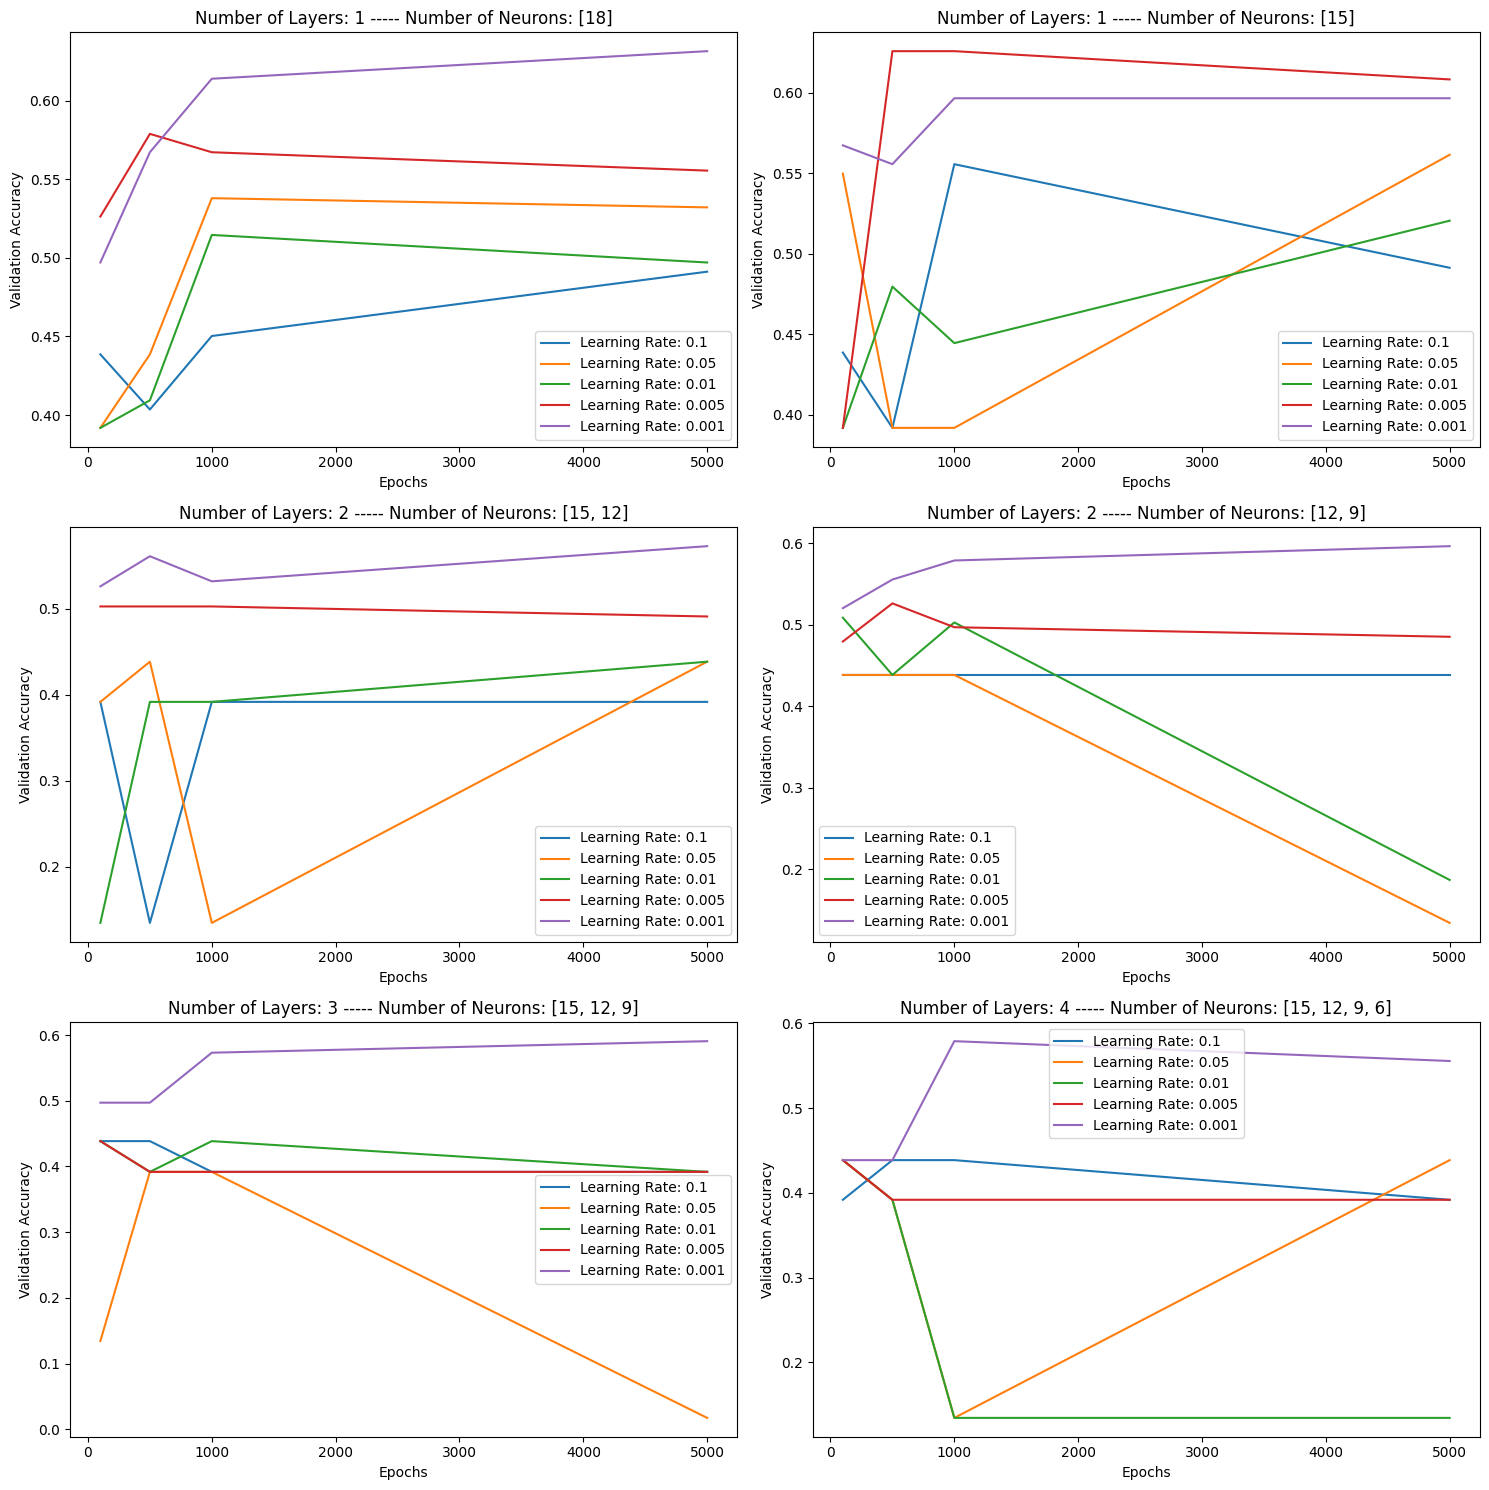

In [12]:
hyper_param_df = pd.read_csv("./Data/2.2.4.csv")
hyper_param_df = hyper_param_df.drop(columns=["Unnamed: 0"])

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

for i, (num_layers, num_neurons) in enumerate(hidden_layers):
    ax = axs[i // 2][i % 2]

    num_layer_df = hyper_param_df[hyper_param_df['num_layers'] == num_layers]

    indices = []
    for num_row in range(num_layer_df.shape[0]):
        if (num_layer_df.iloc[num_row]['num_neurons'] == str(np.array(num_neurons))):
            indices.append(num_row)

    num_neuron_df = num_layer_df.iloc[indices]

    for lr in learning_rates:
        lr_df = num_neuron_df[num_neuron_df['lr'] == lr]

        ax.plot(lr_df['epochs'], lr_df['val_acc'], label=f"Learning Rate: {lr}")

    ax.set_title(f"Number of Layers: {num_layers} ----- Number of Neurons: {num_neurons}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Validation Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()

## Task 2.2.4.2 - Best model hyperparameters
- With `Sigmoid` activation function and `Mini Batch` optimiser with `10` batches

| Learning Rate | Epochs | Num_Layers | Num_Neurons |
|---------------|--------|------------|-------------|
| 0.001         | 5000   | 1          | 18          |

## Task 2.2.4.3 - Metrics vs Hyperparameters

In [13]:
print("With activation function as sigmoid and optimiser as Mini_Batch")
display(hyper_param_df)

With activation function as sigmoid and optimiser as Mini_Batch


,lr,epochs,num_layers,num_neurons,train_loss,train_acc,val_loss,val_acc,val_micro_f1,val_macro_f1,val_weighted_f1,val_precision,val_recall
0,0.100,100,1,[18],1.157750e-02,0.418903,2.507981e-10,0.438596,0.438596,0.101626,0.267437,0.073099,0.166667
1,0.050,100,1,[18],2.019733e-02,0.401400,-6.023392e-01,0.391813,0.391813,0.093838,0.220601,0.065302,0.166667
2,0.010,100,1,[18],1.721536e+00,0.401400,1.721143e+00,0.391813,0.391813,0.093838,0.220601,0.065302,0.166667
3,0.005,100,1,[18],1.137920e+00,0.507585,1.088657e+00,0.526316,0.526316,0.219396,0.445574,0.247926,0.252630
4,0.001,100,1,[18],1.131470e+00,0.526254,1.093108e+00,0.497076,0.497076,0.180247,0.448399,0.177588,0.202421
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.100,5000,4,[15 12 9 6],2.442705e-09,0.401400,3.104589e+01,0.391813,0.391813,0.093838,0.220601,0.065302,0.166667
116,0.050,5000,4,[15 12 9 6],1.136527e-09,0.418903,2.293887e+01,0.438596,0.438596,0.101626,0.267437,0.073099,0.166667
117,0.010,5000,4,[15 12 9 6],2.763437e+00,0.127188,2.652007e+00,0.134503,0.134503,0.039519,0.031892,0.022417,0.166667
118,0.005,5000,4,[15 12 9 6],1.988787e+00,0.401400,2.005500e+00,0.391813,0.391813,0.093838,0.220601,0.065302,0.166667


## Task 2.3 - Evaluating Model

## Task 2.3.1 - Classification report on test set

In [14]:
best_MLP = MLP(lr=0.001, epochs=5000, num_layers=1, num_neurons=np.array([18]), activation='sigmoid', optimiser='Mini_Batch', num_batches=10, progress=False)
best_MLP.train(wine_train_X, wine_train_Y)

test_labels = best_MLP.predict(wine_test_X)
report = classification_report(wine_test_Y, test_labels, zero_division=0)
print(report)

              precision    recall  f1-score   support

         4.0       0.00      0.00      0.00         4
         5.0       0.65      0.69      0.67        49
         6.0       0.59      0.59      0.59        51
         7.0       0.33      0.36      0.35        11

    accuracy                           0.59       115
   macro avg       0.39      0.41      0.40       115
weighted avg       0.57      0.59      0.58       115



## Task 2.3.2 - Comparision of MLR with MLP

|     | Accuracy | Precision | Recall | Weighted f1-score |
|-----|----------|-----------|--------|-------------------|
| MLR | 0.69     | 0.67      | 0.69   | 0.67              |
| MLP | 0.59     | 0.57      | 0.59   | 0.58              |

- As we can observe, `MLR` performed slightly better than `MLP` in terms of all metrics

- This could be attributed to various factors, probably due to possible overfitting to the train data by the MLP model

- This can be justified by checking the number of epochs of the MLP model, which is `5000`

- Inspite of the MLR model being run for higher number of epochs, it does not overfir that highly to the data due to the presence of lesser number of positions for feature extraction, like how the MLP has layers

- The MLP has clear possibility of overfitting in the number of neurons chosen per layer and number of layers as well

- It must also be understood that such strong feature extractors like MLP are not always needed when the data is simple enough

- When the inferences can be easily drawn or when the data is lesser, MLR can be a more favourable choice

- But, when the decision boundaries go to the non-linear space, the performance of MLR falls down quickly as it is a linear model. In such cases, MLPs are a very valuable tool to handle non-linearity as they can model non-linearity using activation functions

- These are the general comparisions between MLR and MLP

## Task 2.4 - Multi-Label Classification

In [15]:
ad_df = pd.read_csv('./Data/advertisement.csv')
ad_df['labels'] = [tuple(sorted(label.split())) for label in ad_df['labels'].values]
ad_df = ad_df.sample(frac=1, ignore_index=True, random_state=0)   # Randomly shuffling the dataset such that the indices are not modified
display(ad_df)

,age,gender,income,education,married,children,city,occupation,purchase_amount,most bought item,labels
0,51,Male,36943.241991,Bachelor,True,1,Tinaburgh,Doctor,130.896177,carpet,"(furniture, home)"
1,50,Female,51286.770062,Bachelor,True,2,Stephaniemouth,Scientist,95.357469,carpet,"(electronics, food, home)"
2,61,Female,60291.173100,Bachelor,False,3,Anthonyland,Artist,73.148970,perfume,"(beauty, clothing, electronics, home)"
3,23,Female,28079.688466,High School,False,0,Santiagoport,Salesman,128.020827,perfume,"(beauty, food, furniture, sports)"
4,52,Female,57172.892713,PhD,False,1,Jessicabury,Retired,101.866142,monitor,"(books, electronics, sports)"
...,...,...,...,...,...,...,...,...,...,...,...
995,48,Female,38521.308595,PhD,True,2,Martinezborough,Salesman,88.538319,pants,"(clothing, electronics, food)"
996,27,Male,51920.621309,Master,True,2,Gonzaleshaven,Lawyer,90.314766,mobile,"(electronics,)"
997,54,Male,54820.225010,PhD,False,3,Carrillohaven,Unemployed,68.858618,chips,"(books, food, sports)"
998,55,Female,55536.327624,PhD,False,2,New Stephen,Salesman,119.926626,dictionary,"(books, furniture)"


In [16]:
categorical_features = ["gender", "education", "married", "city", "occupation", "most bought item"]

for category in categorical_features:
    one_hot = pd.get_dummies(ad_df[category])

    ad_df = ad_df.drop(category, axis=1)
    ad_df = ad_df.join(one_hot.astype(int))

labels = ad_df['labels']
ad_df = ad_df.drop('labels', axis=1)
ad_df = ad_df.join(labels)

display(ad_df)

,age,income,children,purchase_amount,Female,Male,Bachelor,High School,Master,PhD,...,mobile,monitor,novel,pants,perfume,shirt,shoes,sofa,table,labels
0,51,36943.241991,1,130.896177,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"(furniture, home)"
1,50,51286.770062,2,95.357469,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"(electronics, food, home)"
2,61,60291.173100,3,73.148970,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,"(beauty, clothing, electronics, home)"
3,23,28079.688466,0,128.020827,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,"(beauty, food, furniture, sports)"
4,52,57172.892713,1,101.866142,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,"(books, electronics, sports)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,48,38521.308595,2,88.538319,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,"(clothing, electronics, food)"
996,27,51920.621309,2,90.314766,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,"(electronics,)"
997,54,54820.225010,3,68.858618,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"(books, food, sports)"
998,55,55536.327624,2,119.926626,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"(books, furniture)"


In [17]:
ad_df_values = ad_df.to_numpy()

ad_df_X, ad_df_Y = ad_df_values[:, :-1], ad_df_values[:, -1]

ad_train_X, ad_val_test_X, ad_train_Y, ad_val_test_Y = train_test_split(ad_df_X, ad_df_Y, random_state=0)
ad_val_X,   ad_test_X,     ad_val_Y,   ad_test_Y     = train_test_split(ad_val_test_X, ad_val_test_Y, train_size=0.6, random_state=0)

# Replacing missing values with mean of the respective columns/features
ad_train_X = SimpleImputer().fit_transform(ad_train_X)
ad_val_X   = SimpleImputer().fit_transform(ad_val_X)
ad_test_X  = SimpleImputer().fit_transform(ad_test_X)

# Dataset normalization
ad_train_X = normalize(ad_train_X)
ad_val_X   = normalize(ad_val_X)
ad_test_X  = normalize(ad_test_X)

# Dataset standardization
ad_train_X = StandardScaler().fit_transform(ad_train_X)
ad_val_X   = StandardScaler().fit_transform(ad_val_X)
ad_test_X  = StandardScaler().fit_transform(ad_test_X)

In [18]:
mlp_multi_label = MLP(optimiser='Batch', activation='sigmoid', lr=0.01, multiLabel=True, label_threshold=0.2)
mlp_multi_label.train(ad_train_X, ad_train_Y)

Epoch 100 ----- Loss: 5.7537739780423705 ----- Accuracy: 0.6541666666666667
Epoch 200 ----- Loss: 5.753784572047616 ----- Accuracy: 0.6541666666666667
Epoch 300 ----- Loss: 5.75378485306723 ----- Accuracy: 0.6541666666666667
Epoch 400 ----- Loss: 5.753784867346301 ----- Accuracy: 0.6541666666666667
Epoch 500 ----- Loss: 5.753784871301678 ----- Accuracy: 0.6541666666666667
Epoch 600 ----- Loss: 5.753784873275561 ----- Accuracy: 0.6541666666666667
Epoch 700 ----- Loss: 5.753784874409288 ----- Accuracy: 0.6541666666666667
Epoch 800 ----- Loss: 5.753784875115676 ----- Accuracy: 0.6541666666666667
Epoch 900 ----- Loss: 5.753784875582946 ----- Accuracy: 0.6541666666666667
Epoch 1000 ----- Loss: 5.753784875906587 ----- Accuracy: 0.6541666666666667


In [19]:
test_one_hot_labels, test_loss, test_Y = mlp_multi_label.predict(ad_test_X, ad_test_Y)
acc = 1 - hamming_loss(test_Y, test_one_hot_labels)

print(f"Test Accuracy: {acc}")

Test Accuracy: 0.65


In [20]:
sweep_config = {
    'method': 'grid',
    'metric': {'goal': 'maximise', 'name': 'val_acc'},
    'parameters': {
        'activations': {'values': ['sigmoid', 'tanh', 'relu']},
        'optimisers' : {'values': ['SGD', 'Batch', 'Mini_Batch']},
    }
}

opt_act_metrics_ad_df = pd.DataFrame(columns=['activation', 'optimiser', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'val_micro_f1', 'val_macro_f1', 'val_weighted_f1', 'val_precision', 'val_recall'])

In [21]:
# os.environ["WANDB_SILENT"] = "true"
# wandb.login()

# project = 'SMAI_MLP_Multi_Label_Classification_Activation_Optimiser'
# run_num = 1

# sweep_id = wandb.sweep(sweep=sweep_config, project=project)
# print()

# def tuning():
#     global run_num

#     run = wandb.init(name=f'Run 1_{run_num}')

#     activation, optimiser = wandb.config.activations, wandb.config.optimisers

#     print(f"Run {run_num}/9 ----- Activation: {activation} ----- Optimiser: {optimiser}")
#     print()

#     MLP_Multi_Label_tuning = MLP(activation=activation, optimiser=optimiser, multiLabel=True, label_threshold=0.2, progress=False)
#     MLP_Multi_Label_tuning.train(ad_train_X, ad_train_Y)

#     ad_train_pred_one_hot_Y, ad_train_loss, ad_train_Y_one_hot = MLP_Multi_Label_tuning.predict(ad_train_X, ad_train_Y)
#     ad_val_pred_one_hot_Y,   ad_val_loss,   ad_val_Y_one_hot   = MLP_Multi_Label_tuning.predict(ad_val_X,   ad_val_Y)

#     ad_train_accuracy = 1 - hamming_loss(ad_train_Y_one_hot, ad_train_pred_one_hot_Y)

#     ad_val_accuracy    = 1 - hamming_loss( ad_val_Y_one_hot, ad_val_pred_one_hot_Y)
#     ad_val_micro_f1    = f1_score(         ad_val_Y_one_hot, ad_val_pred_one_hot_Y, average='micro',    zero_division=0)
#     ad_val_macro_f1    = f1_score(         ad_val_Y_one_hot, ad_val_pred_one_hot_Y, average='macro',    zero_division=0)
#     ad_val_weighted_f1 = f1_score(         ad_val_Y_one_hot, ad_val_pred_one_hot_Y, average='weighted', zero_division=0)
#     ad_val_precision   = precision_score(  ad_val_Y_one_hot, ad_val_pred_one_hot_Y, average='macro',    zero_division=0)
#     ad_val_recall      = recall_score(     ad_val_Y_one_hot, ad_val_pred_one_hot_Y, average='macro',    zero_division=0)

#     opt_act_metrics_ad_df.loc[len(opt_act_metrics_ad_df)] = [activation, optimiser, ad_train_loss, ad_train_accuracy, ad_val_loss, ad_val_accuracy, ad_val_micro_f1, ad_val_macro_f1, ad_val_weighted_f1, ad_val_precision, ad_val_recall]

#     wandb.log({'activation': activation, 'optimiser': optimiser, 'train_loss': ad_train_loss, 'train_acc': ad_train_accuracy, 'val_loss': ad_val_loss, 'val_acc': ad_val_accuracy})

#     run.finish()
#     run_num += 1

# wandb.agent(sweep_id, tuning)
# wandb.finish()
# opt_act_metrics_ad_df.to_csv("./Data/2.4.2.c.csv")

In [22]:
print("With learning rate of 0.001, 1000 epochs, 2 hidden layers with 15 and 12 neurons and label threshold of 0.2")
opt_act_metrics_ad_df = pd.read_csv("./Data/2.4.2.c.csv")
opt_act_metrics_ad_df = opt_act_metrics_ad_df.drop(columns=["Unnamed: 0"])
display(opt_act_metrics_ad_df)

With learning rate of 0.001, 1000 epochs, 2 hidden layers with 15 and 12 neurons and label threshold of 0.2


,activation,optimiser,train_loss,train_acc,val_loss,val_acc,val_micro_f1,val_macro_f1,val_weighted_f1,val_precision,val_recall
0,sigmoid,SGD,5.753785e+00,0.654167,5.585164,0.664167,0.000000,0.000000,0.000000,0.000000,0.000000
1,sigmoid,Batch,5.753785e+00,0.654167,5.585166,0.664167,0.000000,0.000000,0.000000,0.000000,0.000000
2,sigmoid,Mini_Batch,5.753785e+00,0.654167,5.585164,0.664167,0.000000,0.000000,0.000000,0.000000,0.000000
3,tanh,SGD,5.753785e+00,0.654167,5.585164,0.664167,0.000000,0.000000,0.000000,0.000000,0.000000
4,tanh,Batch,5.753785e+00,0.654167,5.585164,0.664167,0.000000,0.000000,0.000000,0.000000,0.000000
5,tanh,Mini_Batch,5.753785e+00,0.654167,5.585164,0.664167,0.000000,0.000000,0.000000,0.000000,0.000000
6,relu,SGD,-2.182667e+00,0.674833,-2.192274,0.651667,0.242754,0.192633,0.206291,0.381548,0.158551
7,relu,Batch,5.138037e+00,0.649500,4.839974,0.660000,0.023923,0.016667,0.019851,0.041667,0.010417
8,relu,Mini_Batch,-1.036232e+09,0.624833,-2.293333,0.635833,0.209765,0.199233,0.208278,0.385557,0.137856


In [23]:
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
epochs         = [100, 500, 1000, 5000]
hidden_layers  = [
    (1, [18]),
    (1, [15]),
    (2, [15, 12]),
    (2, [12, 9]),
    (3, [15, 12, 9]),
    (4, [15, 12, 9, 6]),
]

sweep_config = {
    'method': 'grid',
    'metric': {'goal': 'maximise', 'name': 'val_acc'},
    'parameters': {
        'lr': {'values': learning_rates},
        'epochs': {'values': epochs},
        'hidden_layers': {'values': hidden_layers},
    }
}

hyper_param_ad_df = pd.DataFrame(columns=['lr', 'epochs', 'num_layers', 'num_neurons', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'val_micro_f1', 'val_macro_f1', 'val_weighted_f1', 'val_precision', 'val_recall'])

In [24]:
# os.environ["WANDB_SILENT"] = "true"
# wandb.login()

# project = 'SMAI_MLP_Multi_Label_Classification_Hyperparameters'
# run_num = 1

# sweep_id = wandb.sweep(sweep=sweep_config, project=project)
# print()

# def tuning():
#     global run_num

#     run = wandb.init(name=f'Run 1_{run_num}')

#     lr, epochs, num_layers, num_neurons = wandb.config.lr, wandb.config.epochs, wandb.config.hidden_layers[0], np.array(wandb.config.hidden_layers[1])

#     print(f"Run {run_num}/120 ----- Learning Rate: {lr} ----- Epochs: {epochs} ----- Number of Layers: {num_layers} ----- Number of Neurons: {num_neurons}")
#     print()

#     MLP_Multi_Label_tuning = MLP(activation='sigmoid', optimiser='Batch', lr=lr, epochs=epochs, num_layers=num_layers, num_neurons=num_neurons, multiLabel=True, label_threshold=0.2, progress=False)
#     MLP_Multi_Label_tuning.train(ad_train_X, ad_train_Y)

#     ad_train_pred_one_hot_Y, ad_train_loss, ad_train_Y_one_hot = MLP_Multi_Label_tuning.predict(ad_train_X, ad_train_Y)
#     ad_val_pred_one_hot_Y,   ad_val_loss,   ad_val_Y_one_hot   = MLP_Multi_Label_tuning.predict(ad_val_X,   ad_val_Y)

#     ad_train_accuracy = 1 - hamming_loss(ad_train_Y_one_hot, ad_train_pred_one_hot_Y)

#     ad_val_accuracy    = 1 - hamming_loss( ad_val_Y_one_hot, ad_val_pred_one_hot_Y)
#     ad_val_micro_f1    = f1_score(         ad_val_Y_one_hot, ad_val_pred_one_hot_Y, average='micro',    zero_division=0)
#     ad_val_macro_f1    = f1_score(         ad_val_Y_one_hot, ad_val_pred_one_hot_Y, average='macro',    zero_division=0)
#     ad_val_weighted_f1 = f1_score(         ad_val_Y_one_hot, ad_val_pred_one_hot_Y, average='weighted', zero_division=0)
#     ad_val_precision   = precision_score(  ad_val_Y_one_hot, ad_val_pred_one_hot_Y, average='macro',    zero_division=0)
#     ad_val_recall      = recall_score(     ad_val_Y_one_hot, ad_val_pred_one_hot_Y, average='macro',    zero_division=0)

#     hyper_param_ad_df.loc[len(hyper_param_ad_df)] = [lr, epochs, num_layers, num_neurons, ad_train_loss, ad_train_accuracy, ad_val_loss, ad_val_accuracy, ad_val_micro_f1, ad_val_macro_f1, ad_val_weighted_f1, ad_val_precision, ad_val_recall]

#     wandb.log({'lr': lr, 'epochs': epochs, 'num_layers': num_layers, 'num_neurons': num_neurons, 'train_loss': ad_train_loss, 'train_acc': ad_train_accuracy, 'val_loss': ad_val_loss, 'val_acc': ad_val_accuracy})

#     run.finish()
#     run_num += 1

# wandb.agent(sweep_id, tuning)
# wandb.finish()
# hyper_param_ad_df.to_csv("./Data/2.4.2.d.csv")

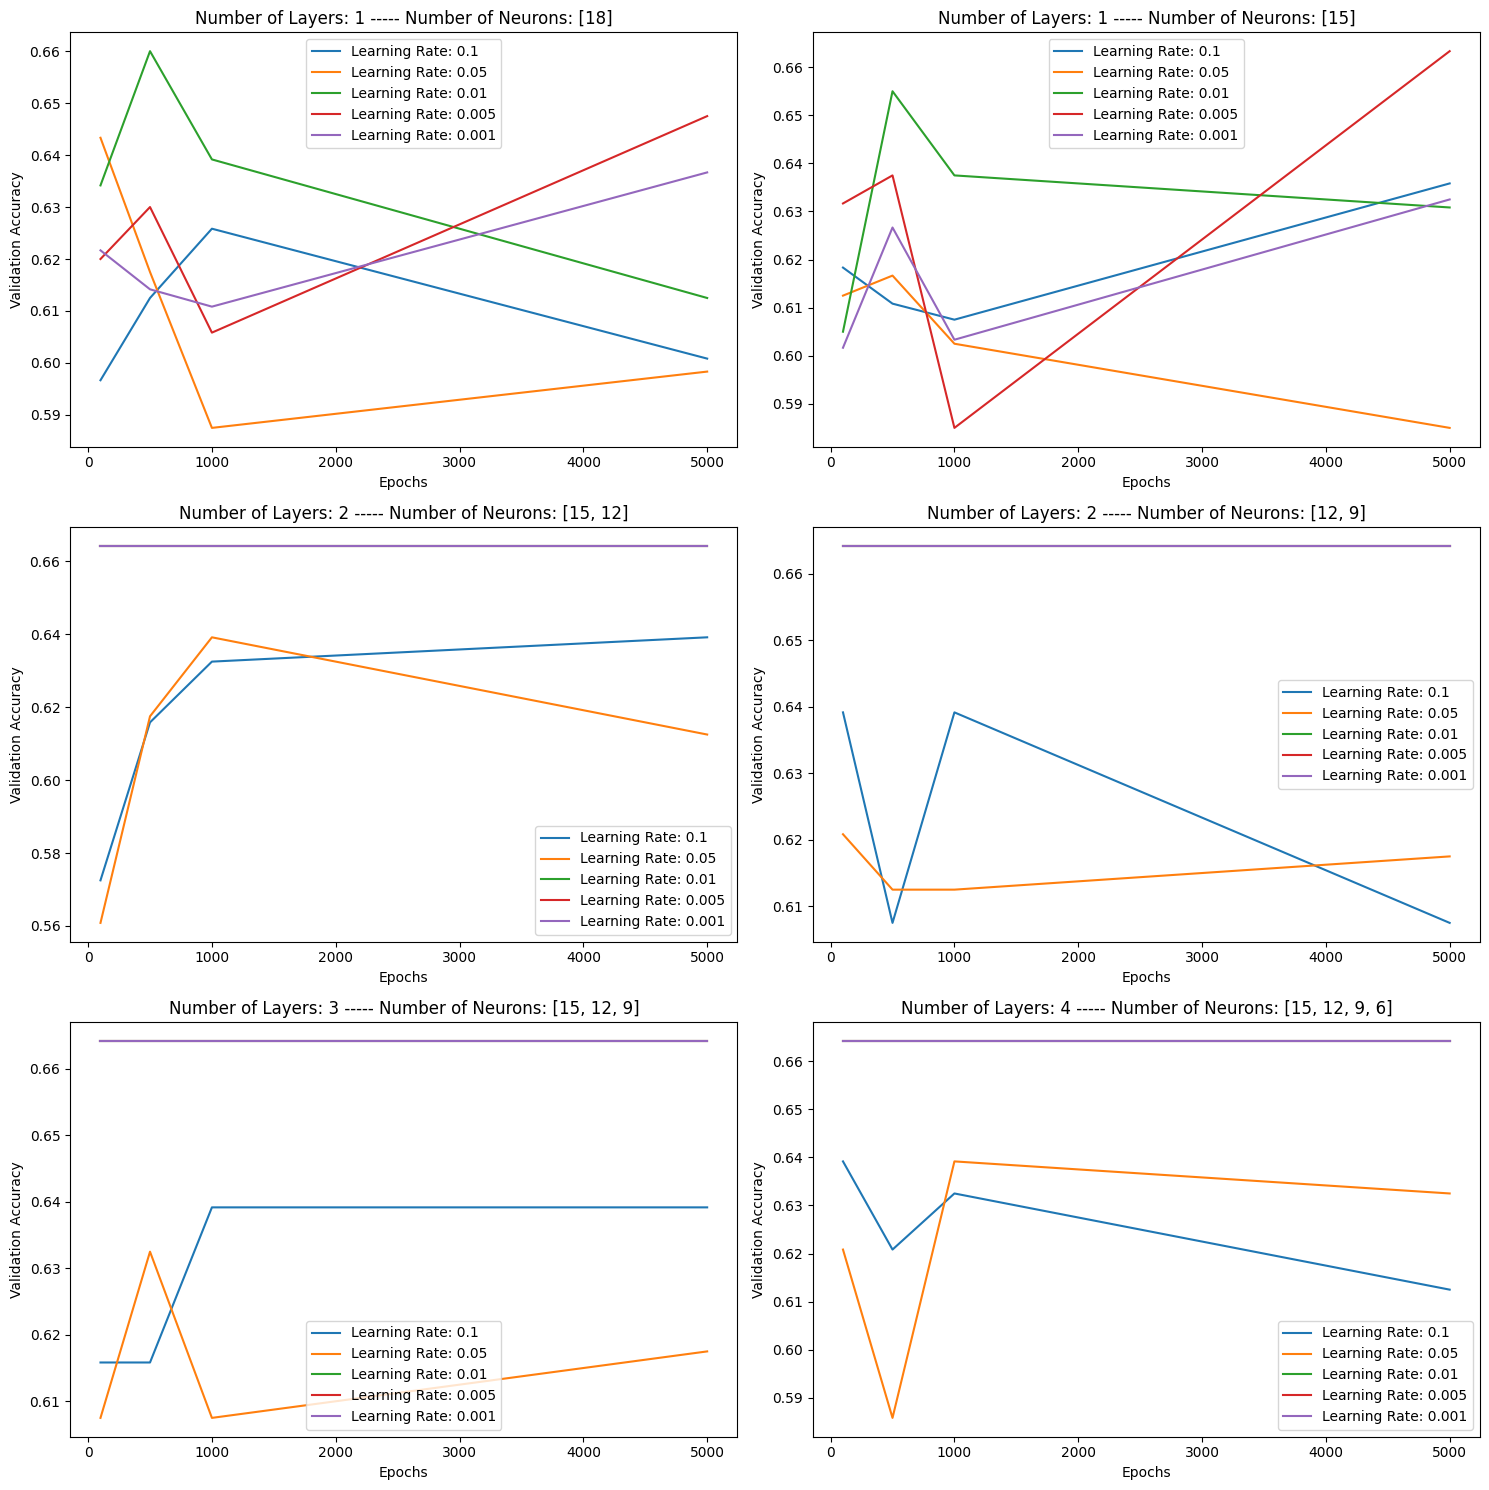

In [25]:
hyper_param_ad_df = pd.read_csv("./Data/2.4.2.d.csv")
hyper_param_ad_df = hyper_param_ad_df.drop(columns=["Unnamed: 0"])

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

for i, (num_layers, num_neurons) in enumerate(hidden_layers):
    ax = axs[i // 2][i % 2]

    num_layer_ad_df = hyper_param_ad_df[hyper_param_ad_df['num_layers'] == num_layers]

    indices = []
    for num_row in range(num_layer_ad_df.shape[0]):
        if (num_layer_ad_df.iloc[num_row]['num_neurons'] == str(np.array(num_neurons))):
            indices.append(num_row)

    num_neuron_ad_df = num_layer_ad_df.iloc[indices]

    for lr in learning_rates:
        lr_df = num_neuron_ad_df[num_neuron_ad_df['lr'] == lr]

        ax.plot(lr_df['epochs'], lr_df['val_acc'], label=f"Learning Rate: {lr}")

    ax.set_title(f"Number of Layers: {num_layers} ----- Number of Neurons: {num_neurons}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Validation Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()

## Task 2.4.2.d.2 - Best model hyperparameters
- With `Sigmoid` activation function and `Batch` optimiser

| Learning Rate | Epochs | Num_Layers | Num_Neurons |
|---------------|--------|------------|-------------|
| 0.005         | 5000   | 1          | 15          |

## Task 2.4.2.d.3 - Metrics vs Hyperparameters

In [26]:
print("With activation function as sigmoid and optimiser as Batch")
display(hyper_param_ad_df)

With activation function as sigmoid and optimiser as Batch


,lr,epochs,num_layers,num_neurons,train_loss,train_acc,val_loss,val_acc,val_micro_f1,val_macro_f1,val_weighted_f1,val_precision,val_recall
0,0.100,100,1,[18],4.931201,0.607167,-3093.490301,0.596667,0.243750,0.136521,0.127472,0.203229,0.208241
1,0.050,100,1,[18],19.262259,0.615667,18.731675,0.643333,0.307443,0.170413,0.188745,0.289965,0.207082
2,0.010,100,1,[18],6.098698,0.645833,6.387697,0.634167,0.283850,0.268162,0.265026,0.405719,0.220629
3,0.005,100,1,[18],5.963582,0.652333,6.314114,0.620000,0.205575,0.202713,0.203674,0.350584,0.146756
4,0.001,100,1,[18],6.096008,0.634500,6.076271,0.621667,0.214533,0.205421,0.206440,0.319389,0.154530
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.100,5000,4,[15 12 9 6],-2.422667,0.615167,-2.386667,0.612500,0.159132,0.056701,0.049525,0.036667,0.125000
116,0.050,5000,4,[15 12 9 6],10.109526,0.614500,10.093128,0.632500,0.202532,0.067961,0.075550,0.046667,0.125000
117,0.010,5000,4,[15 12 9 6],5.753785,0.654167,5.585164,0.664167,0.000000,0.000000,0.000000,0.000000,0.000000
118,0.005,5000,4,[15 12 9 6],5.753785,0.654167,5.585164,0.664167,0.000000,0.000000,0.000000,0.000000,0.000000


## Task 2.4.3 - Metrics on test set for best model

In [27]:
best_Multi_Label_MLP = MLP(lr=0.005, epochs=5000, num_layers=1, num_neurons=np.array([15]), activation='sigmoid', optimiser='Batch', multiLabel=True, label_threshold=0.2, progress=False)
best_Multi_Label_MLP.train(ad_train_X, ad_train_Y)

test_one_hot_labels, test_loss, test_Y = best_Multi_Label_MLP.predict(ad_test_X, ad_test_Y)

ad_metrics = pd.DataFrame(columns=['Accuracy', 'Micro F1', 'Macro F1', 'Weighted F1', 'Precision', 'Recall'])

ad_accuracy    = 1 - hamming_loss(test_Y, test_one_hot_labels)
ad_micro_f1    = f1_score(        test_Y, test_one_hot_labels, average='micro',    zero_division=0)
ad_macro_f1    = f1_score(        test_Y, test_one_hot_labels, average='macro',    zero_division=0)
ad_weighted_f1 = f1_score(        test_Y, test_one_hot_labels, average='weighted', zero_division=0)
ad_precision   = precision_score( test_Y, test_one_hot_labels, average='macro',    zero_division=0)
ad_recall      = recall_score(    test_Y, test_one_hot_labels, average='macro',    zero_division=0)

ad_metrics.loc[len(ad_metrics)] = [ad_accuracy, ad_micro_f1, ad_macro_f1, ad_weighted_f1, ad_precision, ad_recall]

display(ad_metrics)

,Accuracy,Micro F1,Macro F1,Weighted F1,Precision,Recall
0,0.63,0.317972,0.293936,0.288794,0.499966,0.251996
